In [ ]:
!python --version

Python 3.11.13


# ***Redes Neuronales***

## **Librerías y carga de datos**


In [ ]:
!pip install -q tqdm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from tensorflow.keras.layers import (Embedding, Bidirectional, LSTM,
                                     Dense, Dropout)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay,
                             precision_recall_curve, roc_auc_score, roc_curve,  ConfusionMatrixDisplay,  )
from tensorflow.keras.models import save_model
import joblib

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
root_dir = '/content/drive/MyDrive/PDG/data/'
export_dir = '/content/drive/MyDrive/PDG/models/'
#root_dir = "/content/drive/MyDrive/Proyecto-de-Grado-RAD-Alert/Oficial/Ahora-si-este-fue/data/"

In [ ]:
file_original = root_dir + "base_df.xlsx"
file_aug_train = root_dir + "train_oversample_df.xlsx"
file_aug_val  = root_dir + "val_df.xlsx"
file_test = root_dir + "test_df.xlsx"

## **Preprocesamiento**

In [ ]:
TEXT    = "texto"
LABEL   = "etiqueta"
VOCAB   = 30_000
MAXLEN  = 250
EMB_DIM = 128
BATCH   = 64
EPOCHS  = 12

In [ ]:
def build_lstm(vocab=VOCAB, maxlen=MAXLEN, emb_dim=EMB_DIM):
    model = Sequential([
        Embedding(vocab, emb_dim, input_length=maxlen),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [ ]:
def prep_text(train_text, test_text, vocab=VOCAB, maxlen=MAXLEN):
    tok = Tokenizer(num_words=vocab, oov_token="<OOV>")
    tok.fit_on_texts(train_text)
    Xtr = pad_sequences(tok.texts_to_sequences(train_text), maxlen=maxlen, padding="post")
    Xte = pad_sequences(tok.texts_to_sequences(test_text),  maxlen=maxlen, padding="post")
    return Xtr, Xte

## Definición Modelo

In [ ]:
def train_and_eval(name, df_tr, df_te):
    print(f"\n>>> {name.upper()} <<<")
    Xtr_text, ytr = df_tr[TEXT].astype(str), df_tr[LABEL].astype(int).values
    Xte_text, yte = df_te[TEXT].astype(str), df_te[LABEL].astype(int).values

    Xtr, Xte = prep_text(Xtr_text, Xte_text)

    model = build_lstm()
    es = EarlyStopping(patience=2, restore_best_weights=True, verbose=1)
    model.fit(
        Xtr, ytr,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_split=0.1,
        callbacks=[es],
        verbose=2
    )

    y_prob = model.predict(Xte, batch_size=BATCH).ravel()
    prec, rec, thr = precision_recall_curve(yte, y_prob)
    f1 = 2 * prec * rec / (prec + rec + 1e-9)
    best_thr = thr[np.nanargmax(f1)]
    y_pred = (y_prob >= best_thr).astype(int)
    print(f"Umbral óptimo F1: {best_thr:.3f}\n")
    print(classification_report(yte, y_pred, digits=3))

    cm = confusion_matrix(yte, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["No crítico","Crítico"]).plot(cmap="Blues")
    plt.title(f"CM – {name}"); plt.show()

    auc = roc_auc_score(yte, y_prob)
    fpr, tpr, _ = roc_curve(yte, y_prob)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}"); plt.plot([0,1],[0,1],"k--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC – {name}")
    plt.legend(); plt.show()

    return model

## **Evaluación Modelos**


>>> ORIGINAL <<<


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/12
38/38 - 12s - 316ms/step - accuracy: 0.8300 - loss: 0.4139 - val_accuracy: 0.8636 - val_loss: 0.2986
Epoch 2/12
38/38 - 1s - 39ms/step - accuracy: 0.9000 - loss: 0.2456 - val_accuracy: 0.8826 - val_loss: 0.2658
Epoch 3/12
38/38 - 1s - 39ms/step - accuracy: 0.9376 - loss: 0.1742 - val_accuracy: 0.8939 - val_loss: 0.2873
Epoch 4/12
38/38 - 1s - 39ms/step - accuracy: 0.9595 - loss: 0.1273 - val_accuracy: 0.9091 - val_loss: 0.3161
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Umbral óptimo F1: 0.482

              precision    recall  f1-score   support

           0      0.967     0.921     0.944       535
           1      0.718     0.863     0.784       124

    accuracy                          0.910       659
   macro avg      0.842     0.892     0.864       659
weighted avg      0.920     0.910     0.913       659



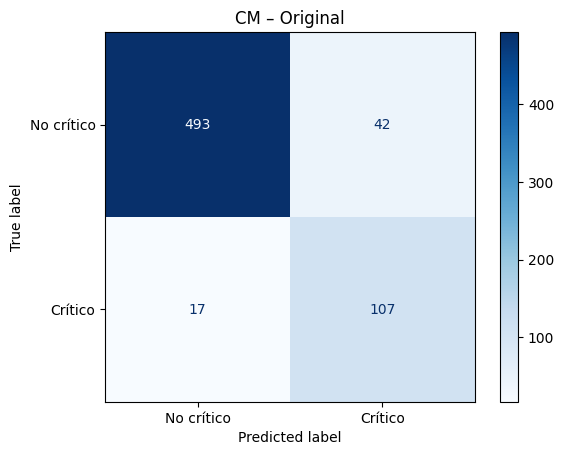

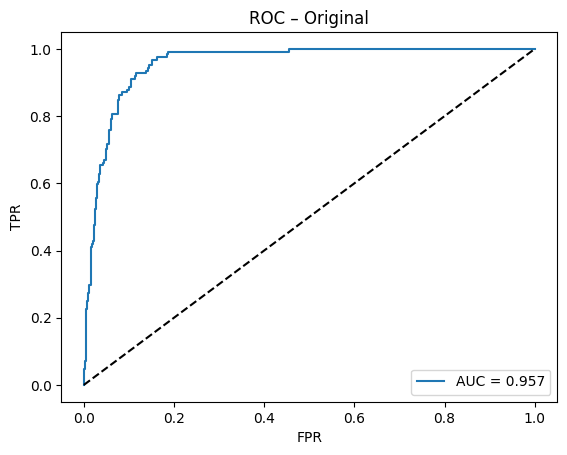


>>> TEST FINAL (ORIGINAL) <<<
Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


38/38 - 14s - 381ms/step - accuracy: 0.8203 - loss: 0.4248 - val_accuracy: 0.8674 - val_loss: 0.3041
Epoch 2/12
38/38 - 7s - 175ms/step - accuracy: 0.9004 - loss: 0.2379 - val_accuracy: 0.8788 - val_loss: 0.3329
Epoch 3/12
38/38 - 1s - 39ms/step - accuracy: 0.9414 - loss: 0.1761 - val_accuracy: 0.8939 - val_loss: 0.2689
Epoch 4/12
38/38 - 2s - 65ms/step - accuracy: 0.9586 - loss: 0.1223 - val_accuracy: 0.8864 - val_loss: 0.2787
Epoch 5/12
38/38 - 1s - 37ms/step - accuracy: 0.9764 - loss: 0.0793 - val_accuracy: 0.9167 - val_loss: 0.3206
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step
Umbral óptimo F1: 0.716

              precision    recall  f1-score   support

           0      0.974     0.938     0.956        81
           1      0.773     0.895     0.829        19

    accuracy                          0.930       100
   macro avg      0.874     0.917     0.893       100
weighted avg      0.936     0.930     0

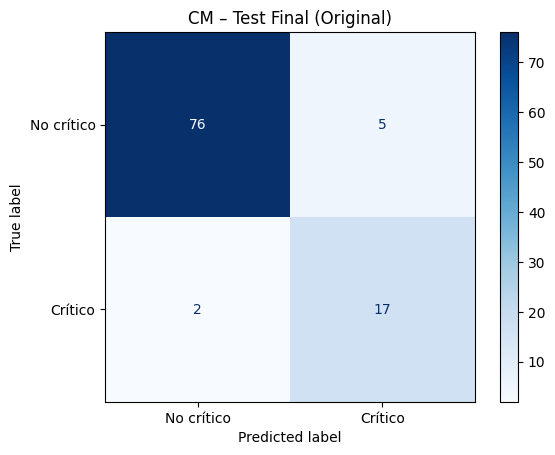

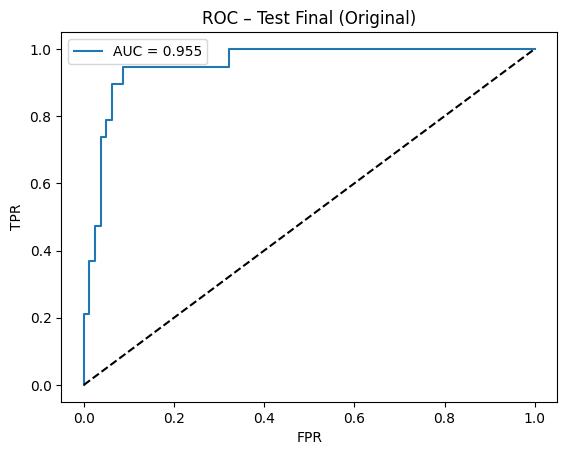

<Sequential name=sequential_1, built=True>

In [ ]:
df_orig = pd.read_excel(file_original)
df_test = pd.read_excel(file_test)
df_o_tr, df_o_te = train_test_split(
    df_orig, test_size=0.2, stratify=df_orig[LABEL], random_state=42
)

model_orig = train_and_eval("Original", df_o_tr, df_o_te)
train_and_eval("Test Final (Original)", df_o_tr, df_test)

| Modelo | Validación | Accuracy | Precision | Recall | F1-score |
| ------ | ---------- | -------- | --------- | ------ | -------- |
| LSTM   | Original   | 0.910    | 0.842     | 0.892  | 0.864    |
| LSTM   | Test Final | 0.930    | 0.874     | 0.917  | 0.893    |


El modelo LSTM entrenado con el conjunto original mostró un desempeño robusto tanto en la validación interna como en la tercera validación sobre datos no vistos. En el conjunto de validación, alcanzó una precisión (precision) de 0.842, un recall de 0.892 y un F1-score de 0.864 (macro promedio), con una exactitud global de 0.910. Al evaluarse sobre el conjunto test final, el modelo mantuvo su rendimiento, obteniendo un accuracy de 0.930, una precisión de 0.874, un recall de 0.917 y un F1-score de 0.893 (macro promedio). Estos resultados demuestran una alta capacidad de generalización y estabilidad, evidenciando que el modelo no solo aprende patrones relevantes en los datos de entrenamiento, sino que también logra identificar correctamente los casos críticos en muestras completamente nuevas, lo que lo posiciona como una herramienta confiable para la alerta automatizada de hallazgos críticos en radiología.


>>> AUMENTADO_BALANCEADO <<<
Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 - 7s - 142ms/step - accuracy: 0.8463 - loss: 0.3799 - val_accuracy: 0.9233 - val_loss: 0.1957
Epoch 2/12
48/48 - 2s - 38ms/step - accuracy: 0.9451 - loss: 0.1625 - val_accuracy: 0.9410 - val_loss: 0.1555
Epoch 3/12
48/48 - 2s - 42ms/step - accuracy: 0.9704 - loss: 0.0921 - val_accuracy: 0.9263 - val_loss: 0.2443
Epoch 4/12
48/48 - 3s - 53ms/step - accuracy: 0.9832 - loss: 0.0554 - val_accuracy: 0.9381 - val_loss: 0.1890
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Umbral óptimo F1: 0.265

              precision    recall  f1-score   support

           0      0.943     0.953     0.948       535
           1      0.788     0.750     0.769       124

    accuracy                          0.915       659
   macro avg      0.865     0.852     0.858       659
weighted avg      0.914     0.915     0.914       659



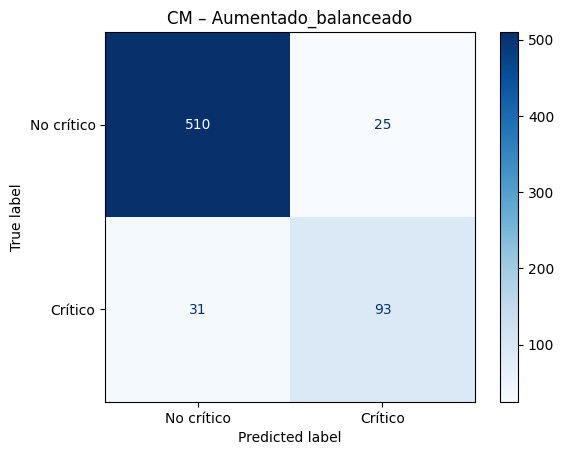

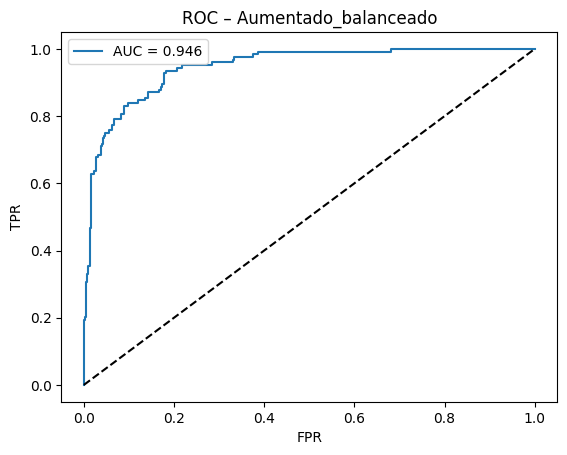


>>> TEST FINAL (AUMENTADO_BALANCEADO) <<<
Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 - 6s - 135ms/step - accuracy: 0.8515 - loss: 0.3883 - val_accuracy: 0.9322 - val_loss: 0.1769
Epoch 2/12
48/48 - 2s - 41ms/step - accuracy: 0.9514 - loss: 0.1564 - val_accuracy: 0.9499 - val_loss: 0.1332
Epoch 3/12
48/48 - 3s - 53ms/step - accuracy: 0.9708 - loss: 0.0906 - val_accuracy: 0.9440 - val_loss: 0.1686
Epoch 4/12
48/48 - 2s - 37ms/step - accuracy: 0.9839 - loss: 0.0546 - val_accuracy: 0.9322 - val_loss: 0.2574
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
Umbral óptimo F1: 0.597

              precision    recall  f1-score   support

           0      0.952     0.975     0.963        81
           1      0.882     0.789     0.833        19

    accuracy                          0.940       100
   macro avg      0.917     0.882     0.898       100
weighted avg      0.939     0.940     0.939       100



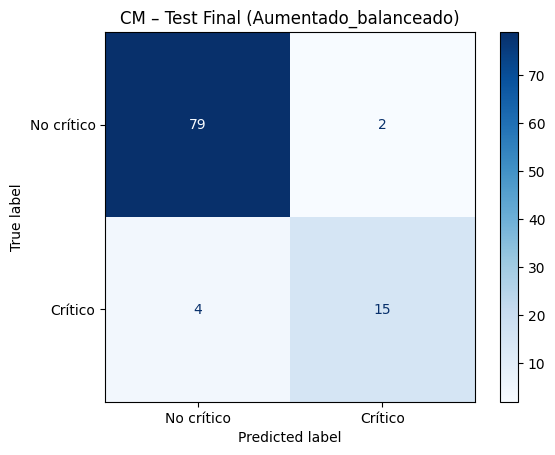

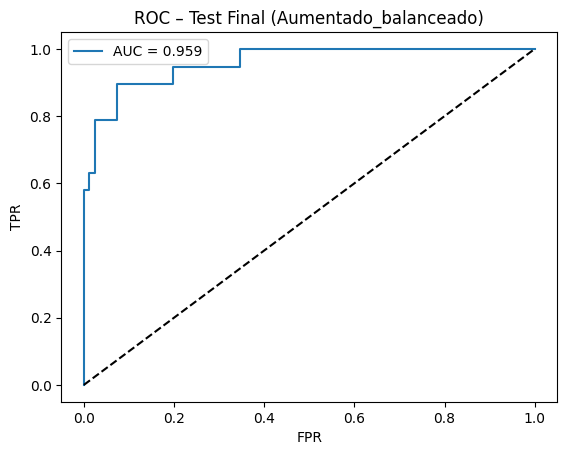

<Sequential name=sequential_3, built=True>

In [ ]:
df_aug_tr = pd.read_excel(file_aug_train)
df_aug_te = pd.read_excel(file_aug_val)

model_aug  = train_and_eval("Aumentado_balanceado", df_aug_tr, df_aug_te)
train_and_eval("Test Final (Aumentado_balanceado)", df_aug_tr, df_test)

| Modelo           | Validación | Accuracy | Precision | Recall | F1-score |
| ---------------- | ---------- | -------- | --------- | ------ | -------- |
| LSTM (Aumentado) | Aumentado  | 0.915    | 0.865     | 0.852  | 0.858    |
| LSTM (Aumentado) | Test Final | 0.940    | 0.917     | 0.882  | 0.898    |


El modelo LSTM entrenado con el conjunto aumentado y balanceado evidenció un desempeño robusto y estable tanto en la validación interna como en la prueba final sobre datos no vistos. En la evaluación sobre el set de validación, el modelo alcanzó un accuracy de 0.915 y un macro F1-score de 0.858, con una precisión de 0.865 y un recall de 0.852. Estos resultados reflejan un balance adecuado entre la detección de casos críticos y la minimización de falsos positivos. Al aplicarse sobre el conjunto de test final, el modelo mantuvo e incluso mejoró algunas métricas, logrando un accuracy de 0.940, una precisión macro de 0.917, un recall de 0.882 y un F1-score macro de 0.898. Este comportamiento demuestra una excelente capacidad de generalización y una mejora consistente al incorporar técnicas de aumento y balanceo de datos, confirmando la utilidad de estos enfoques para optimizar el rendimiento del modelo en escenarios clínicos reales.